Loading pretrained weight for Darknet19...
0 1
tensor(0.8638)
4 0.6494392156600952 177 192 533 576


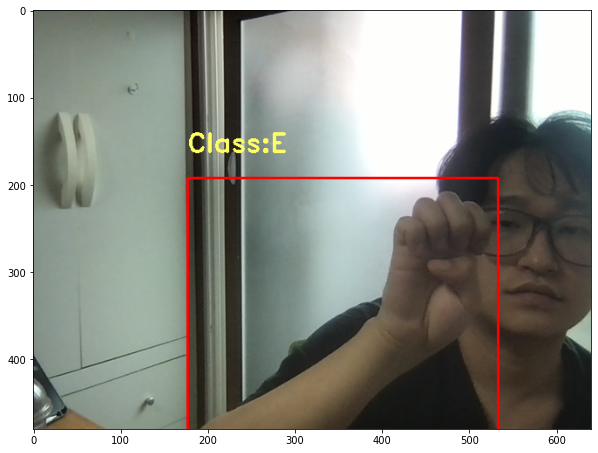

In [54]:
import torch
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from yolov2 import Yolov2
from utils import pred_boxes_to_list_boxes
import matplotlib.pyplot as plt

label2cat = {0: 'A', 1: 'B', 2:'C', 3:'D', 4:'E'}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# label1_39
img_path = './data/train/label4_24.png'
model_path = './saved/checkpoint-epoch180.pth.tar'

transform = A.Compose([
    A.Resize(416, 416),
    A.Normalize(mean=[0,0,0], std=[1,1,1]),
    ToTensorV2()
])

model = Yolov2(n_classes=5)
model = model.to(device)
model.eval()

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state'])

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
org_img = img
org_img_size = img.shape # (W, H)
G = 13
w_scale = org_img_size[0] / G
h_scale = org_img_size[1] / G

img = transform(image=img)['image']
img = img.unsqueeze(0)
img = img.to(device)

anchors_wh = [(2.5221, 3.3145), (3.19275, 4.00944), (4.5587, 4.09892), (5.47112, 7.84053),
                        (6.2364, 8.0071)]

with torch.no_grad():
    pred = model(img).permute(0, 2, 3, 1)
    pred = pred.reshape(1, 13, 13, 5, 10)
    all_pred_boxes = pred_boxes_to_list_boxes(pred, anchors_wh, 0)
    
for pred in all_pred_boxes:
    _, cls, conf, x, y, w, h = pred
    cls = int(cls)
    x = x * w_scale
    y = y * h_scale
    w = w * w_scale
    h = h * h_scale
    x1, y1 = int(x - w/2), int(y - h/2)
    x2, y2 = int(x + w/2), int(y + h/2)
    
    print(cls, conf, x1, y1, x2, y2)
    
    cv2.rectangle(org_img, (x1, y1), (x2, y2), (255, 0, 0), thickness=2)
    cv2.putText(org_img, "Class:" + str(label2cat[cls]), (x1, y1-30), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1, color=(255, 255, 100), thickness=2)

plt.figure(figsize=(10,10))
plt.imshow(org_img)
    